In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import glob
from datetime import datetime as dt
import seaborn as sns
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
np.set_printoptions(suppress=True)

pd.set_option("display.max_colwidth",999)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

%matplotlib inline

## load 2017 data plus additional data cleaning

In [2]:
df_sf_2017 = pd.read_json('df_sf_2017')
df_sf_2017.loc[df_sf_2017.cancellation_policy == 'flexible_new', 'cancellation_policy'] = "flexible"
prop_type = set(df_sf_2017.property_type.values)
keep = ['Apartment', 'House', 'Condomonium']
drop = list(set(prop_type).difference(keep))
df_sf_2017['property_type_new'] = df_sf_2017['property_type']
df_sf_2017.loc[df_sf_2017.property_type.isin(drop), 'property_type_new'] = "Other"


df_sf_2017['amenities_count'] = (df_sf_2017.amenities.apply(lambda x: len(x.split(','))))
df_sf_2017.is_business_travel_ready.fillna(value='f', inplace=True)

df_sf_2017.security_deposit.fillna(value='$0.00', inplace=True)
df_sf_2017['security_deposit'].replace('[\$,]', '', regex=True, inplace=True)
df_sf_2017['security_deposit'] = df_sf_2017.security_deposit.astype(float) 


In [22]:
def grid_searching (param_grid, model):

    grid_search = GridSearchCV(model, 
                               param_grid=param_grid, cv=5, 
                               n_jobs=-1, scoring=make_scorer(f1_score))
    fit = grid_search.fit(X_train, y_train)
    predicted = fit.predict(X_test)
    return grid_search.best_params_


In [3]:
# columns_to_keep = ['accommodates','bed_type', 'extra_people', 'price','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type']
# columns_to_keep = ['access_filled', 'house_rules_filled','space_filled','accommodates','bed_type', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled','host_picture_url_filled', 'cancellation_policy', 'room_type', 'property_type_new']

columns_to_keep = ['host_length', 'amenities_count', 'review_scores_rating', 'host_response_rate', 'access_filled', 'house_rules_filled','space_filled','accommodates', 'extra_people', 'price_per_guest', 'price_per_bedroom','guests_included', 'host_about_filled', 'cancellation_policy', 'room_type', 'property_type_new', 'instant_bookable', 'calculated_host_listings_count', 'minimum_nights']


## Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
def split_data(start_month, end_month):
    df_sf_temp = df_sf_2017.copy()
    X_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)][columns_to_keep]
    y_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)]['popular']

    X_test = df_sf_temp[df_sf_temp['month'] == end_month][columns_to_keep]
    y_test = df_sf_temp[df_sf_temp['month'] == end_month]['popular']


    return X_train, y_train, X_test, y_test
    

In [25]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

In [218]:
def predict_data(X_train, y_train, X_test, y_test):
    
    param_grid = {'n_estimators': [500, 1000, 1500], 
                  'max_features': ['auto'], 
                  'max_depth': [None, 15],
                  'class_weight': [None, {0: .8, 1: .2}, {0: .9, 1: .1}, {0: .99, 1: .01}]}

    model = RandomForestClassifier()
    
    best_parameters = grid_searching(param_grid, model)
    print(best_parameters)
    rf = RandomForestClassifier(n_estimators = best_parameters['n_estimators'], n_jobs=-1, random_state=0, max_depth = best_parameters['max_depth'], class_weight = best_parameters['class_weight'])
#     rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1, random_state=0, class_weight = {0: .99, 1: .01})
   
    rf.fit(X_train, y_train)
    
    predicted = rf.predict(X_test)
    pickle.dump(rf, open('rf_model'+ str(model_num) + '.p', 'wb'))
    scores[0][model_num] = accuracy_score(y_test, predicted)
    scores[1][model_num] = recall_score(y_test, predicted)
    scores[2][model_num] = precision_score(y_test, predicted)
    scores[3][model_num] = f1_score(y_test, predicted)
    return scores, rf

## Loop through all 9 test sets and print the scores

In [220]:
%%time
scores = np.zeros(shape=(4,9))
model_num = 0
start_month = 1
end_month = 4
while end_month <13:
    X_train, y_train, X_test, y_test = split_data(start_month, end_month)
    X_train = transform_dummify(X_train, columns_to_keep)
    X_test = transform_dummify(X_test, columns_to_keep)
    scores, rf = predict_data(X_train, y_train, X_test, y_test)
    print(start_month, end_month, model_num)
    start_month += 1
    end_month += 1
    model_num += 1
    print(scores)

{'class_weight': {0: 0.9, 1: 0.1}, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 500}
1 4 0
[[0.95546093 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.83913329 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9        0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86850153 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
{'class_weight': {0: 0.8, 1: 0.2}, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 1500}
2 5 1
[[0.95546093 0.95561927 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.83913329 0.80615586 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.9        0.9311649  0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86850153 0.86416286 0.         0.         0.         0.
  0.         0.         0.        ]]
{'class_weight': {0

# Average scores across all of 2017 with the RF model

In [221]:
accuracy_2017 = np.mean(scores[0])
recall_2017 = np.mean(scores[1])
precision_2017 = np.mean(scores[2])
f1_score_2017 = np.mean(scores[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9510394426862019
0.8367017636067986
0.9132446844769156
0.8729239273514097


In [8]:
# Calculates permutation feature importance for a fitted model. Returns numpy array of permutation importance for each feature

def permutation_importance(model, X_test, y_test, scorer=accuracy_score):
    
    feat_importances = np.zeros(X_test.shape[1])
    test_score = scorer(model.predict(X_test), y_test)
    for i in range(X_test.shape[1]):
        X_test_shuffled = shuffle_column(X_test, i)
        test_score_permuted = scorer(model.predict(X_test_shuffled), y_test)
        feat_importances[i] = test_score - test_score_permuted
    return feat_importances

In [9]:
#reorders the column values

def shuffle_column(X, feature_index):
    
    X_new = X.copy()
    np.random.shuffle(X_new[:,feature_index])
    return X_new    

In [ ]:
X_train, y_train, X_test, y_test = split_data(start_month, end_month)
X_train = transform_dummify(X_train, columns_to_keep)
X_test = transform_dummify(X_test, columns_to_keep)
    
rf_model = pickle.load(open('rf_model8.p', 'rb'))
rf_pred_prob = rf_model.predict_proba(X_test)

In [17]:
rf_permutation_importance = permutation_importance(rf_model, np.array(X_test), np.array(y_test), scorer=f1_score)
rf_permutation_importance

array([0.05129228, 0.02865678, 0.21223144, 0.14877966, 0.01434112,
       0.03120173, 0.00454746, 0.01692655, 0.02428431, 0.09747806,
       0.05303184, 0.00198429, 0.01169419, 0.03196056, 0.1517232 ,
       0.01374536, 0.0137914 , 0.00642472, 0.        , 0.        ,
       0.00648703, 0.00742537, 0.00046442, 0.01357846, 0.00972317,
       0.00264544, 0.0282308 , 0.02404285])

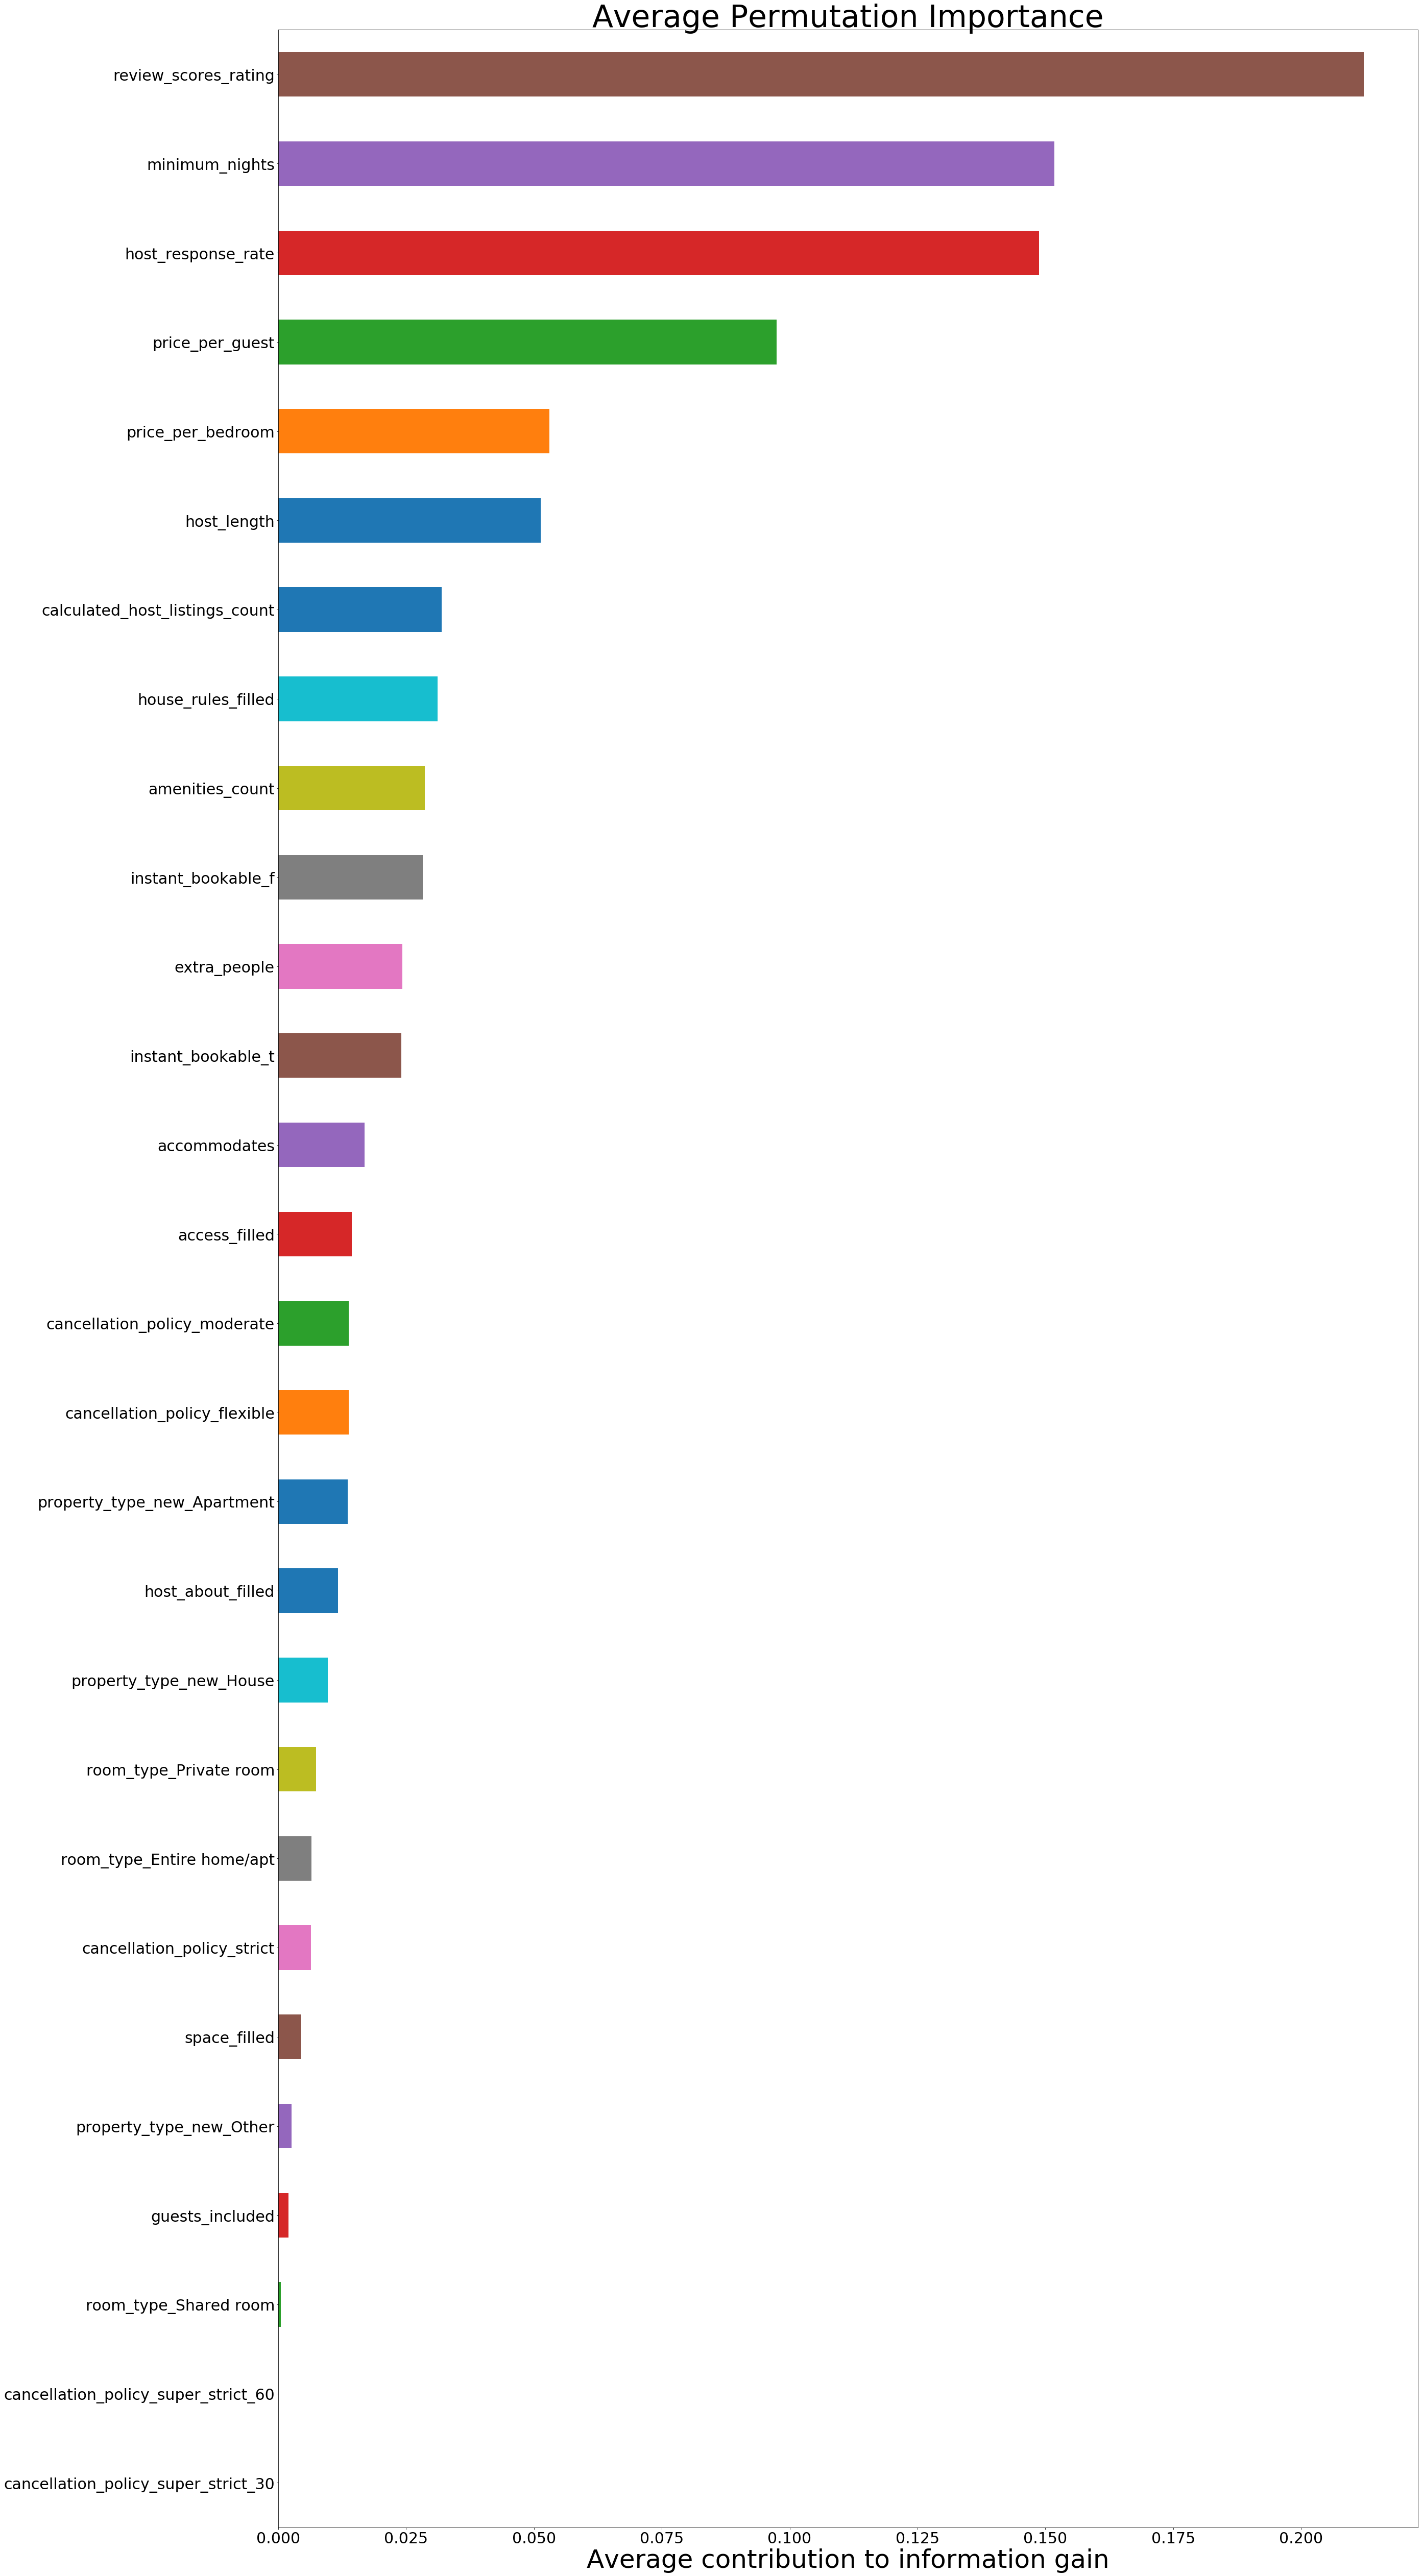

In [18]:
b_feat_scores = pd.Series(rf_permutation_importance,
                           index=X_train.columns)
b_feat_scores = b_feat_scores.sort_values()
ax = b_feat_scores.plot(kind='barh', figsize=(40,90), fontsize=30)
ax.set_title('Average Permutation Importance', fontsize=60)
ax.set_xlabel('Average contribution to information gain',fontsize=50 );

plt.gcf()
plt.savefig('permutation_import')

## permutation importantance - old (first round)

In [133]:
rf_permutation_importance = permutation_importance(rf, np.array(X_test), np.array(y_test), scorer=f1_score)
rf_permutation_importance

array([ 0.02554822,  0.04584343,  0.22714524,  0.13286182,  0.02121073,
        0.0324306 ,  0.01140432,  0.01180934,  0.02758485,  0.13297079,
        0.04182354,  0.01009677,  0.00776263,  0.        ,  0.02239319,
        0.1113051 ,  0.00056179,  0.00262223, -0.00021223,  0.00077337,
        0.00086122,  0.        , -0.00051193,  0.00330904,  0.00008726,
        0.        ,  0.        ,  0.0042667 ,  0.0015478 ,  0.0009492 ,
        0.        ,  0.00193541,  0.00513707,  0.00193541,  0.00211302,
        0.00038655,  0.00086122,  0.00077337,  0.00107242,  0.00408601,
        0.00107242,  0.00128319,  0.00077337,  0.        ,  0.        ,
        0.0012486 ,  0.        ,  0.00241234,  0.        ,  0.        ,
        0.00038655,  0.0015478 ,  0.00038655,  0.        ,  0.        ,
        0.00077337,  0.        ,  0.        ,  0.00732966,  0.01099762,
        0.00354927,  0.        ,  0.        ,  0.00955487,  0.00472061,
        0.00077337,  0.00430242,  0.00960535,  0.00378738,  0.01

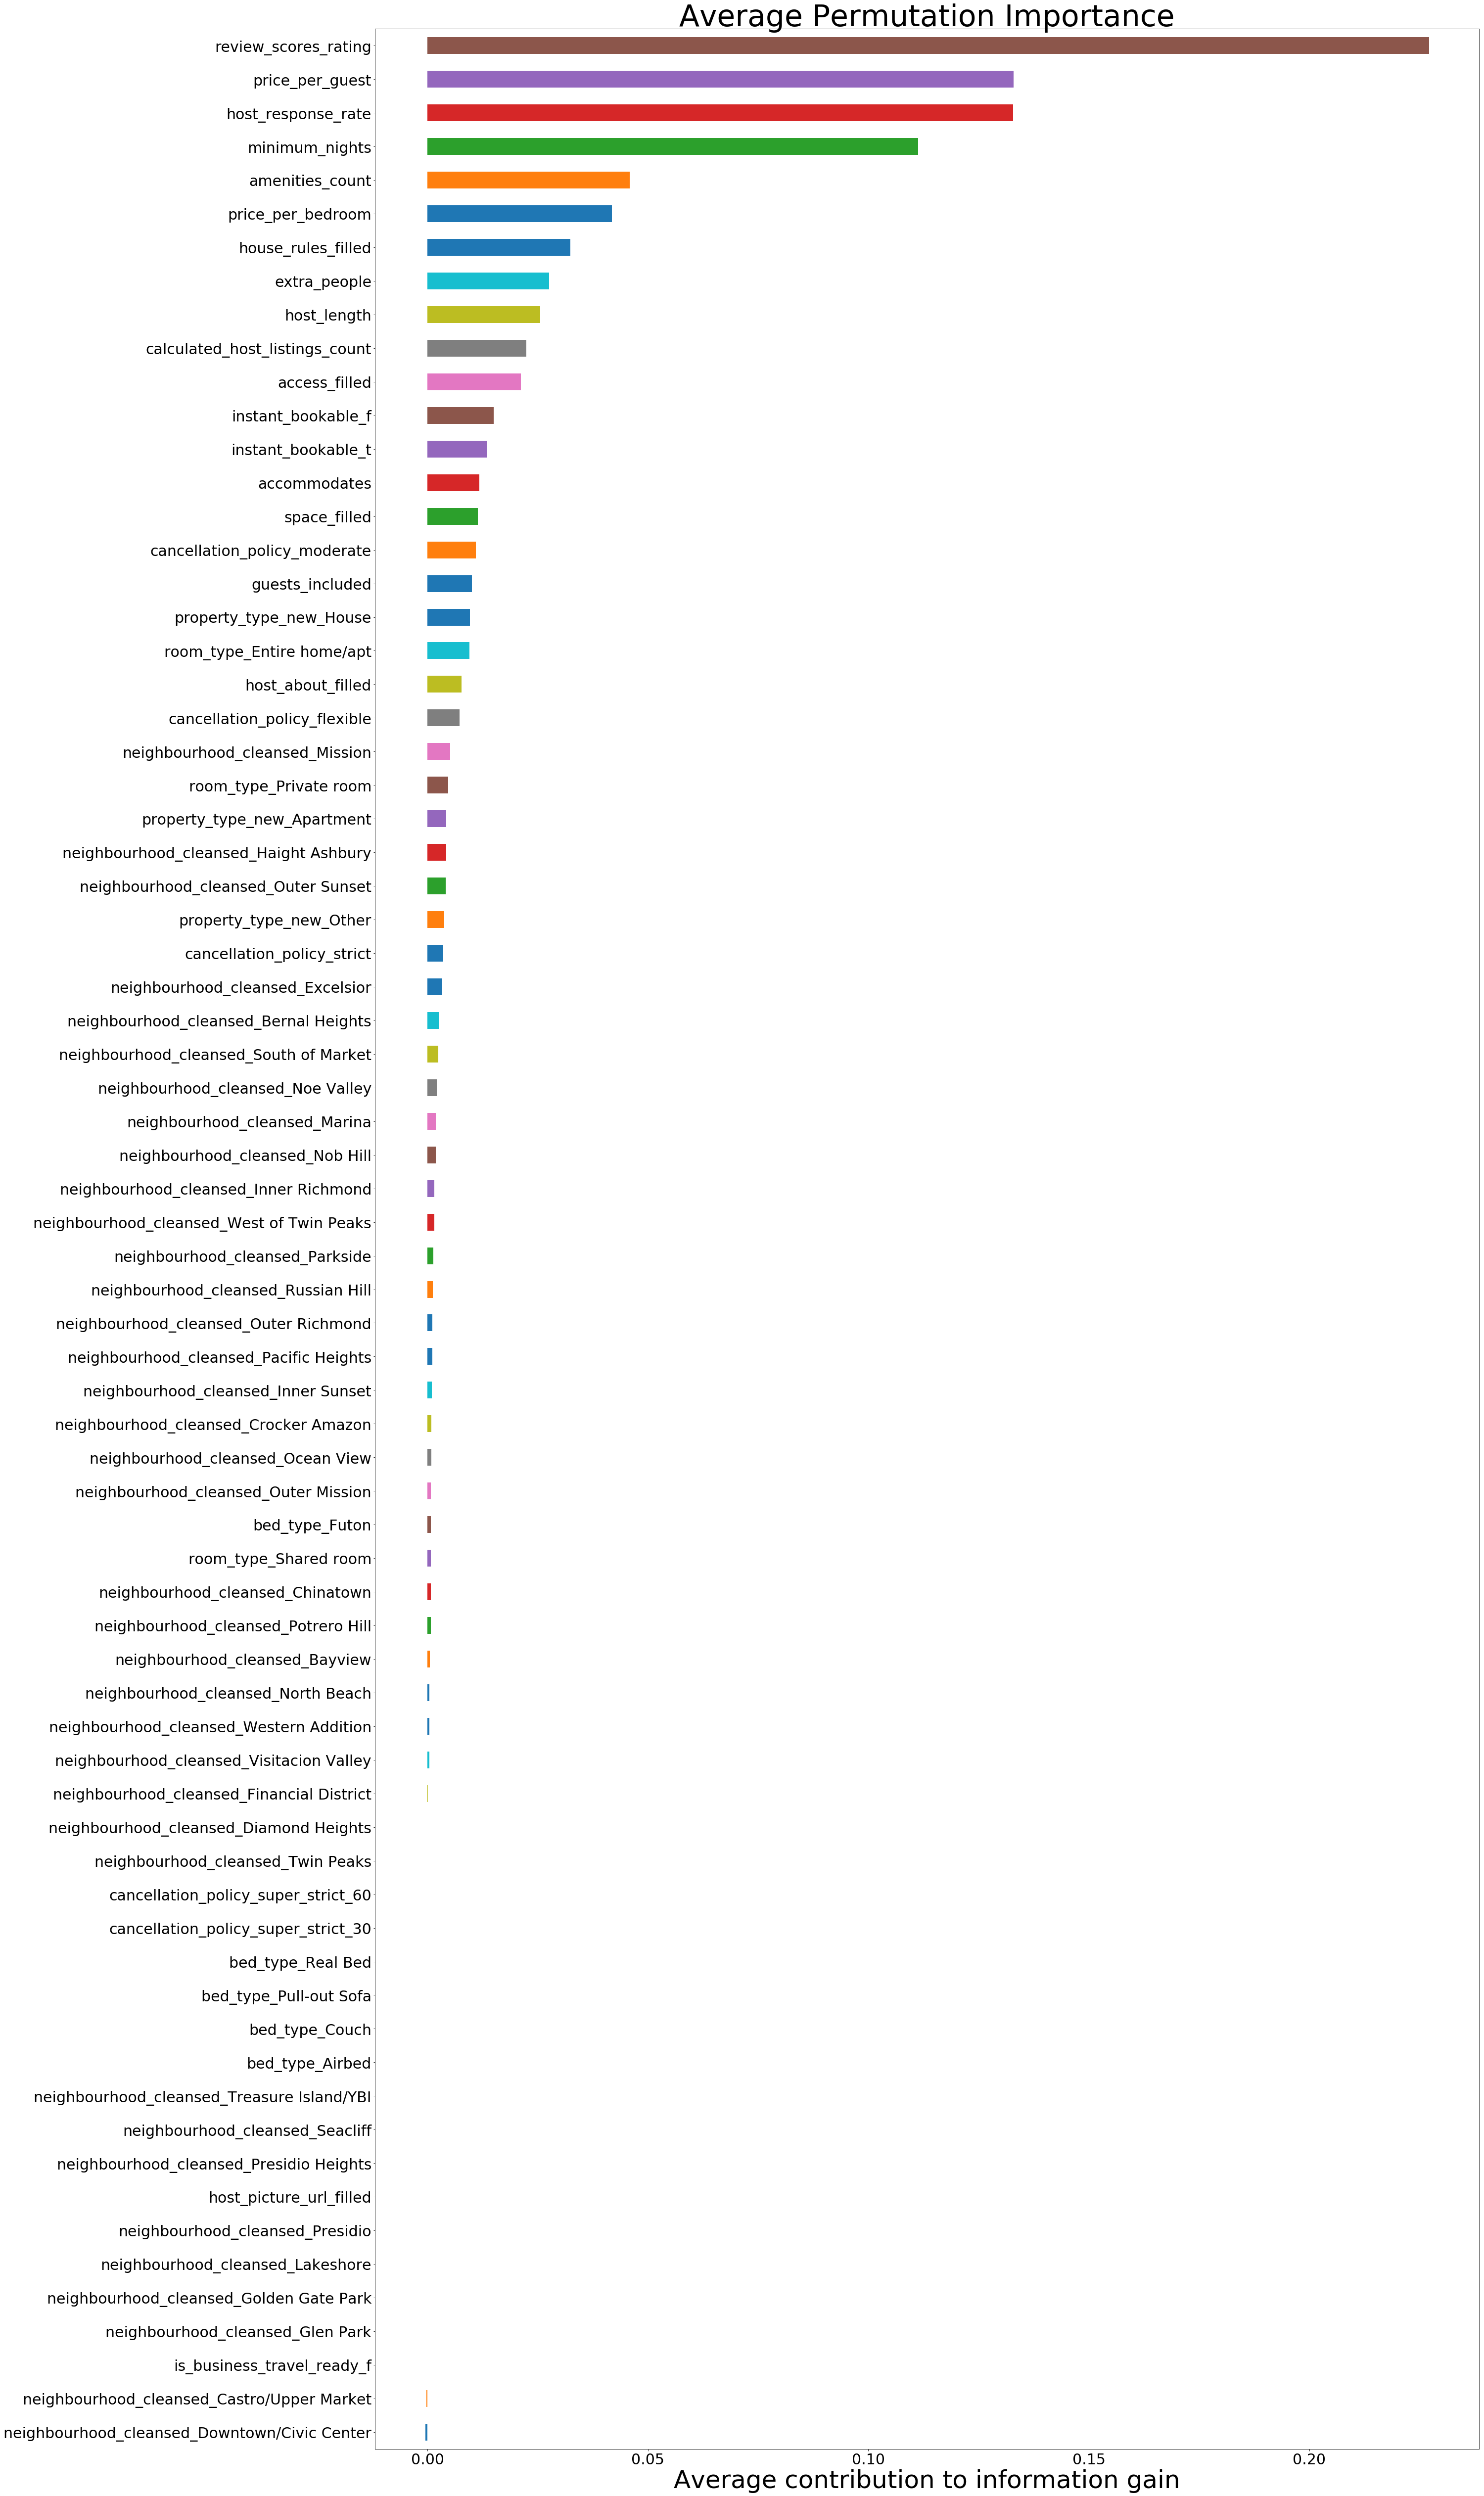

In [156]:
b_feat_scores = pd.Series(rf_permutation_importance,
                           index=X_train.columns)
b_feat_scores = b_feat_scores.sort_values()
ax = b_feat_scores.plot(kind='barh', figsize=(40,90), fontsize=30)
ax.set_title('Average Permutation Importance', fontsize=60)
ax.set_xlabel('Average contribution to information gain',fontsize=50 );

plt.gcf()
plt.savefig('permutation_import')

## XGBoost Model

In [4]:
from xgboost import XGBClassifier

In [50]:
def split_data(start_month, end_month):
    df_sf_temp = df_sf_2017.copy()
    X_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)][columns_to_keep]
    y_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)]['popular']

    X_test = df_sf_temp[df_sf_temp['month'] == end_month][columns_to_keep]
    y_test = df_sf_temp[df_sf_temp['month'] == end_month]['popular']


    return X_train, y_train, X_test, y_test
    

In [51]:
def transform_dummify(X, columns_to_keep):
    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

#     print(list(df_temp.columns.values))
    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)
    return df_temp

In [66]:
def predict_data(X_train, y_train, X_test, y_test):
    
    param_grid = {'learning_rate': [0.1, 0.5, 1, 1.5], 
                 'max_depth': [23, 15]}

    model = XGBClassifier()

    best_params = grid_searching(param_grid, model)

    xgboost = XGBClassifier(n_jobs=-1, booster='gbtree', n_estimators=1000, learning_rate=1, max_depth = best_params['max_depth'], objective='binary:logistic')

    xgboost.fit(X_train, y_train)
    
    predicted = xgboost.predict(X_test)
    pickle.dump(xgboost, open('xgboost_model'+ str(model_num) + '.p', 'wb'))
    scores_xgboost[0][model_num] = accuracy_score(y_test, predicted)
    scores_xgboost[1][model_num] = recall_score(y_test, predicted)
    scores_xgboost[2][model_num] = precision_score(y_test, predicted)
    scores_xgboost[3][model_num] = f1_score(y_test, predicted)
    return xgboost, scores_xgboost

In [63]:
scores_xgboost = np.zeros(shape=(4,9))
model_num = 0
start_month = 1
end_month = 4

In [67]:
%%time
while end_month <13:
    X_train, y_train, X_test, y_test = split_data(start_month, end_month)
    X_train = transform_dummify(X_train, columns_to_keep)
    X_test = transform_dummify(X_test, columns_to_keep)
    xgboost, scores_xgboost = predict_data(X_train, y_train, X_test, y_test)
    print(start_month, end_month, model_num)
    start_month += 1
    end_month += 1
    model_num += 1
    print(scores_xgboost)

1 4 0
[[0.95649672 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86802364 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88192128 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87491727 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
2 5 1
[[0.95649672 0.95493119 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.86802364 0.84479371 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.88192128 0.89211618 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.87491727 0.86781029 0.         0.         0.         0.
  0.         0.         0.        ]]
3 6 2
[[0.95649672 0.95493119 0.95445229 0.         0.         0.
  0.         0.         0.        ]
 [0.86802364 0.84479371 0.84735202 0.         0.         0.
  0.         0.         0.        ]
 [0.88192128 0.89211

In [68]:
accuracy_2017 = np.mean(scores_xgboost[0])
recall_2017 = np.mean(scores_xgboost[1])
precision_2017 = np.mean(scores_xgboost[2])
f1_score_2017 = np.mean(scores_xgboost[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)

0.9514364355691516
0.8650437931585487
0.8905477616628682
0.8774310061317645


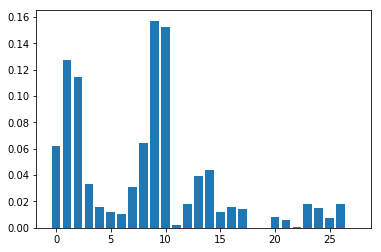

In [12]:
from matplotlib import pyplot
xg_model = pickle.load(open('xgboost_model4.p', 'rb'))
xg_model.feature_importances_
pyplot.bar(range(len(xg_model.feature_importances_)), xg_model.feature_importances_)
pyplot.show()

# important features include host_length, amenities_count, review_scores_rating, price per guest, and price per bedroom

In [6]:
columns_to_keep

['host_length',
 'amenities_count',
 'review_scores_rating',
 'host_response_rate',
 'access_filled',
 'house_rules_filled',
 'space_filled',
 'accommodates',
 'extra_people',
 'price_per_guest',
 'price_per_bedroom',
 'guests_included',
 'host_about_filled',
 'cancellation_policy',
 'room_type',
 'property_type_new',
 'instant_bookable',
 'calculated_host_listings_count',
 'minimum_nights']

## ADA Boosting model test with one test quarter

In [117]:
from sklearn.ensemble import AdaBoostClassifier #For Classification

In [118]:
param_grid = {'learning_rate': [0.1, 0.5, 1, 1.5, 2]}
model = AdaBoostClassifier()

best_params = grid_searching(param_grid, model)

clf = AdaBoostClassifier(n_estimators = 1000, 
                         learning_rate = best_params['learning_rate']) 
clf.fit(X_train,y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=1000, random_state=None)

In [119]:
prediction = clf.predict(X_test)

In [120]:
accuracy_score(y_test, prediction)

0.8769708827252849

In [121]:
recall_score(y_test, prediction)

0.571897570584373

In [122]:
precision_score(y_test, prediction)

0.6762422360248447

In [123]:
f1_score(y_test, prediction)

0.6197082888651725

## Gradient Boosting model test with one quarter

In [121]:
from sklearn.ensemble import GradientBoostingClassifier #For Classification

In [146]:
clf_gradient = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.0)
clf_gradient.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [147]:
pred = clf_gradient.predict(X_test)

In [148]:
accuracy_score(y_test, pred)

0.924272068132121

In [149]:
recall_score(y_test, pred)

0.7657430730478589

In [150]:
precision_score(y_test, pred)

0.8095872170439414

In [151]:
f1_score(y_test, pred)

0.7870550161812296

# Logistic Regression model test

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
def split_data(start_month, end_month):
    df_sf_temp = df_sf_2017.copy()
    X_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)][columns_to_keep]
    y_train = df_sf_temp[(df_sf_temp['month'] >= start_month) & (df_sf_temp['month'] < end_month)]['popular']

    X_test = df_sf_temp[df_sf_temp['month'] == end_month][columns_to_keep]
    y_test = df_sf_temp[df_sf_temp['month'] == end_month]['popular']
    
    return X_train, y_train, X_test, y_test
    

In [40]:
def transform_logistic(X, columns_to_keep):

    df_temp = X[columns_to_keep]
    data_dummies = pd.DataFrame([])
    drop = []
    
    #dummify columns
    for column in columns_to_keep:
        if (df_temp[column].dtypes == 'O'):
            drop.append(column)
            dummies = pd.get_dummies(df_temp[column], prefix= column, drop_first=True)
            data_dummies = pd.concat([data_dummies, dummies], axis=1)

    #join with original df
    df_temp = df_temp.join(data_dummies)

    #drop columns that were dummified
    df_temp.drop(drop, axis=1, inplace = True)

    return df_temp

In [41]:
def predict_logistic(X_train, y_train, X_test, y_test):
    model = LogisticRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    beta_coef.append(model.coef_)
    scores_logit[0][model_num] = accuracy_score(y_test, prediction)
    scores_logit[1][model_num] = recall_score(y_test, prediction)
    scores_logit[2][model_num] = precision_score(y_test, prediction)
    scores_logit[3][model_num] = f1_score(y_test, prediction)
    return scores_logit, beta_coef

In [42]:
beta_coef = []
scores_logit = np.zeros(shape=(4,9))
model_num = 0
start_month = 1
end_month = 4

In [43]:
%%time
while end_month <13:
    X_train, y_train, X_test, y_test = split_data(start_month, end_month)
    X_train = transform_logistic(X_train, columns_to_keep)
    X_test = transform_logistic(X_test, columns_to_keep)
    scores, beta_coef = predict_logistic(X_train, y_train, X_test, y_test)
    print(start_month, end_month, model_num)
    start_month += 1
    end_month += 1
    model_num += 1
    print(scores_logit)
    break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


1 4 0
[[0.83381287 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.16283651 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.59472422 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.2556701  0.         0.         0.         0.         0.
  0.         0.         0.        ]]
CPU times: user 1.07 s, sys: 216 ms, total: 1.28 s
Wall time: 1.26 s


In [ ]:
## logistic model not very good. 

In [ ]:
accuracy_2017 = np.mean(scores_logit[0])
recall_2017 = np.mean(scores_logit[1])
precision_2017 = np.mean(scores_logit[2])
f1_score_2017 = np.mean(scores_logit[3])
print(accuracy_2017)
print(recall_2017)
print(precision_2017)
print(f1_score_2017)